In [ ]:
# Start out importing some libraries

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from IPython.display import Image
import requests
import json
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from mpl_toolkits.basemap import Basemap
import random
# enables inline plots, without it plots don't show up in the notebook
%matplotlib inline

geolocator = Nominatim(user_agent="location code")




In [ ]:
# Then import lat/lon dataset

In [3]:
location_df = pd.read_csv('http://web.mta.info/developers/data/nyct/subway/Stations.csv')
location_df.tail(5)

,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude
492,517,517,S15,SIR,Staten Island,Prince's Bay,SI,SIR,Open Cut,40.525507,-74.200064
493,518,518,S14,SIR,Staten Island,Pleasant Plains,SI,SIR,Embankment,40.522410,-74.217847
494,519,519,S13,SIR,Staten Island,Richmond Valley,SI,SIR,Open Cut,40.519631,-74.229141
495,522,522,S09,SIR,Staten Island,Tottenville,SI,SIR,At Grade,40.512764,-74.251961
496,523,523,S11,SIR,Staten Island,Arthur Kill,SI,SIR,At Grade,40.516578,-74.242096


In [ ]:
# Create a sample of the df to use to debug code... commented these out

In [3]:
# df_size=3
# sample=location_df.sample(df_size).reset_index()
# sample.drop(sample.columns[0], axis=1, inplace=True)
# sample

In [ ]:
# geolocator = Nominatim(user_agent="location code")

# address_list=[]

# for i in range(497):
#     lat = location_df.iat[i, 9]
#     lon = location_df.iat[i, 10]
#     lat_lon = str(lat) + "," + str(lon)
#     address = geolocator.reverse(lat_lon)
#     address_list.append(address)
# location_df['Address']=address_list
    
# #print(address_list)   
# location_df.tail(5)


In [4]:
# This section appends walkscore and Benson score to the lat/lon dataset by calling the WalkScore API

# First create the strings to feed into the web address
inputs=[]
for i in range(497):
    lat = location_df.iat[i, 9]
    lon = location_df.iat[i, 10]
    lat_lon_input = 'lat='+str(lat) + '&lon=' + str(lon)
    inputs.append(lat_lon_input)

# Then extract the WalkScores for each location from the API's web interface
walk_score=[]
for i in inputs:
    url = f'http://api.walkscore.com/score?format=json&{i}&wsapikey=24c9469a038f55c85cbbba8abeadcfcb'
    page = requests.get(url)
    walkscore_dict = json.loads(page.text)    
    walk_score.append(int(walkscore_dict['walkscore']))
location_df['WalkScore']=walk_score


#Now normalize the walkscores to the largest value to create "Benson" score
max_walk_score=max(walk_score)
normalized_walk_score=[]
for i in walk_score:
    norm=i/max_walk_score
    normalized_walk_score.append(norm)    
location_df['Benson WalkScore']=normalized_walk_score 

location_df.tail(5)

,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,WalkScore,Benson WalkScore
492,517,517,S15,SIR,Staten Island,Prince's Bay,SI,SIR,Open Cut,40.525507,-74.200064,70,0.70
493,518,518,S14,SIR,Staten Island,Pleasant Plains,SI,SIR,Embankment,40.522410,-74.217847,67,0.67
494,519,519,S13,SIR,Staten Island,Richmond Valley,SI,SIR,Open Cut,40.519631,-74.229141,56,0.56
495,522,522,S09,SIR,Staten Island,Tottenville,SI,SIR,At Grade,40.512764,-74.251961,52,0.52
496,523,523,S11,SIR,Staten Island,Arthur Kill,SI,SIR,At Grade,40.516578,-74.242096,70,0.70


In [35]:
#Creating dummy columns and values for other benson scores (placeholders)

location_df['Income']=[0 for i in range(497)]
location_df['Benson Income Score']=[.7 for i in range(497)]
location_df['Benson Tech Score']=[.5 for i in range(497)]
location_df['Benson Transit Score']=[.6 for i in range(497)]
location_df.tail(5)

,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,WalkScore,Benson WalkScore,Income,Benson Income Score,Benson Tech Score,Benson Transit Score
492,517,517,S15,SIR,Staten Island,Prince's Bay,SI,SIR,Open Cut,40.525507,-74.200064,70,0.70,0,0.7,0.5,0.6
493,518,518,S14,SIR,Staten Island,Pleasant Plains,SI,SIR,Embankment,40.522410,-74.217847,67,0.67,0,0.7,0.5,0.6
494,519,519,S13,SIR,Staten Island,Richmond Valley,SI,SIR,Open Cut,40.519631,-74.229141,56,0.56,0,0.7,0.5,0.6
495,522,522,S09,SIR,Staten Island,Tottenville,SI,SIR,At Grade,40.512764,-74.251961,52,0.52,0,0.7,0.5,0.6
496,523,523,S11,SIR,Staten Island,Arthur Kill,SI,SIR,At Grade,40.516578,-74.242096,70,0.70,0,0.7,0.5,0.6


In [39]:
# Sort by benson score 

location_df=location_df.sort_values('Benson WalkScore')
location_df.head(10)

,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,WalkScore,Benson WalkScore,Income,Benson Income Score,Benson Tech Score,Benson Transit Score
485,510,510,S22,SIR,Staten Island,New Dorp,SI,SIR,Open Cut,40.573480,-74.117210,0,0.00,0,0.7,0.5,0.6
200,199,199,H19,IND,Rockaway,Broad Channel,Q,A S,At Grade,40.608382,-73.815925,47,0.47,0,0.7,0.5,0.6
199,199,199,H04,IND,Rockaway,Broad Channel,Q,A S,At Grade,40.608382,-73.815925,47,0.47,0,0.7,0.5,0.6
449,448,448,702,IRT,Flushing,Mets - Willets Point,Q,7,Elevated,40.754622,-73.845625,47,0.47,0,0.7,0.5,0.6
495,522,522,S09,SIR,Staten Island,Tottenville,SI,SIR,At Grade,40.512764,-74.251961,52,0.52,0,0.7,0.5,0.6
198,198,198,H03,IND,Rockaway,Howard Beach - JFK Airport,Q,A,At Grade,40.660476,-73.830301,54,0.54,0,0.7,0.5,0.6
487,512,512,S20,SIR,Staten Island,Bay Terrace,SI,SIR,Embankment,40.556400,-74.136907,55,0.55,0,0.7,0.5,0.6
494,519,519,S13,SIR,Staten Island,Richmond Valley,SI,SIR,Open Cut,40.519631,-74.229141,56,0.56,0,0.7,0.5,0.6
207,206,206,H08,IND,Rockaway,Beach 44 St,Q,A,Viaduct,40.592943,-73.776013,57,0.57,0,0.7,0.5,0.6
490,515,515,S17,SIR,Staten Island,Annadale,SI,SIR,Open Cut,40.540460,-74.178217,59,0.59,0,0.7,0.5,0.6


In [40]:
location_df.tail(10)

,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,WalkScore,Benson WalkScore,Income,Benson Income Score,Benson Tech Score,Benson Transit Score
232,231,231,D22,IND,6th Av - Culver,Grand St,M,B D,Subway,40.718267,-73.993753,100,1.0,0,0.7,0.5,0.6
231,230,619,D21,IND,6th Av - Culver,Broadway-Lafayette St,M,B D F M,Subway,40.725297,-73.996204,100,1.0,0,0.7,0.5,0.6
230,229,601,D19,IND,6th Av - Culver,14 St,M,F M,Subway,40.738228,-73.996209,100,1.0,0,0.7,0.5,0.6
229,228,228,D18,IND,6th Av - Culver,23 St,M,F M,Subway,40.742878,-73.992821,100,1.0,0,0.7,0.5,0.6
228,227,607,D17,IND,6th Av - Culver,34 St - Herald Sq,M,B D F M,Subway,40.749719,-73.987823,100,1.0,0,0.7,0.5,0.6
227,226,609,D16,IND,6th Av - Culver,42 St - Bryant Pk,M,B D F M,Subway,40.754222,-73.984569,100,1.0,0,0.7,0.5,0.6
226,225,225,D15,IND,6th Av - Culver,47-50 Sts - Rockefeller Ctr,M,B D F M,Subway,40.758663,-73.981329,100,1.0,0,0.7,0.5,0.6
225,224,224,B10,IND,6th Av - Culver,57 St,M,F,Subway,40.763972,-73.977450,100,1.0,0,0.7,0.5,0.6
233,232,232,F14,IND,6th Av - Culver,2 Av,M,F,Subway,40.723402,-73.989938,100,1.0,0,0.7,0.5,0.6
406,405,405,634,IRT,Lexington Av,23 St,M,6,Subway,40.739864,-73.986599,100,1.0,0,0.7,0.5,0.6


In [10]:
location_df.to_csv('full_location_dataset.csv')

# I passed this dataset on to Steven and Alex where they appended values for the Tech 
# and Income scores. I also used this dataset in Tableau where I created the WalkScore map 
# and bar chart


In [167]:
#Importing the above dataset again after Tech and Income scores had been appended

location_df_v2 = pd.read_csv('location_all_bensons.csv')

In [168]:
location_df_v2.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,WalkScore,Benson WalkScore,Zipcodes,Benson Tech Score,key,Benson Income Score
0,0,15.0,15.0,16.0,16.0,R21,BMT,Broadway - Brighton,8 St - NYU,M,R W,Subway,40.730328,-73.992629,100.0,1.0,10003,1.000000,0.0,0.50576
1,1,408.0,408.0,407.0,407.0,636,IRT,Lexington Av,Astor Pl,M,6,Subway,40.730054,-73.991070,100.0,1.0,10003,0.998086,0.0,0.50576
2,2,116.0,116.0,117.0,602.0,L03,BMT,Canarsie,Union Sq - 14 St,M,L,Subway,40.734789,-73.990730,100.0,1.0,10003,0.993882,0.0,0.50576
3,3,407.0,407.0,406.0,602.0,635,IRT,Lexington Av,14 St - Union Sq,M,4 5 6,Subway,40.734673,-73.989951,100.0,1.0,10003,0.992578,0.0,0.50576
4,4,14.0,14.0,15.0,602.0,R20,BMT,Broadway - Brighton,14 St - Union Sq,M,N Q R W,Subway,40.735736,-73.990568,100.0,1.0,10003,0.990958,0.0,0.50576


In [189]:
# At this point I needed to append the MTA Turnstile data, but there was not a clean mapping
# between the datasets. Therefore, I used google spreadsheets to do a vlookup between 
# "Stop Name" (in location dataset) and "STATION" (in MTA turnstile dataset). I then manually
# went through the list to ensure we had the top locations mapped. I also deleted lesser
# stations with duplicate names

df=pd.read_csv('mapped_data_no_duplicates.csv')

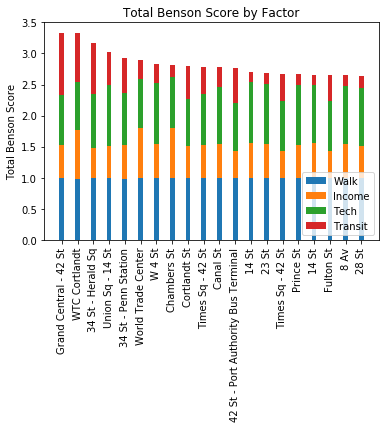

In [190]:
# Now we create the final graphic, the stacked bar chart of benson scores


# Calc and sort on Total Benson Score
df['Total Benson Score']=df['Benson Income Score']+df['Benson Transit Score']+df['Benson WalkScore']+df['Benson Tech Score']
df=df.sort_values('Total Benson Score', ascending=False)

# Set number of bars to show
N = 20
top_location_df=df.head(N)

# Generate chart
benson_walk = top_location_df['Benson WalkScore'].values
benson_income = top_location_df['Benson Income Score'].values
benson_tech = top_location_df['Benson Tech Score'].values
benson_transit = top_location_df['Benson Transit Score'].values
station_names = top_location_df['Stop Name'].values
ind = np.arange(N)    # the x locations for the groups
width = 0.3       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, benson_walk, width)
p2 = plt.bar(ind, benson_income, width,
             bottom=benson_walk)
p3 = plt.bar(ind, benson_tech, width,
             bottom=benson_walk+benson_income)
p4 = plt.bar(ind, benson_transit, width,
             bottom=benson_walk+benson_income+benson_tech)

plt.ylabel('Total Benson Score')
plt.title('Total Benson Score by Factor')
plt.xticks(ind, station_names, rotation=90)
plt.yticks(np.arange(0, 4, .5))
plt.legend((p1[0], p2[0], p3[0], p4[0]), ('Walk', 'Income', 'Tech','Transit'), loc=4)

plt.show()

In [296]:
final_mapping.to_csv('final_mapping.csv')